In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [126]:
holiday = pd.read_csv('data/braga_holidays_and_weekends_2021_2023.csv')

In [127]:
energy1 = pd.read_csv("data/energia_202109-202112.csv", encoding='ISO-8859-1')
energy2 = pd.read_csv("data/energia_202201-202212.csv", encoding='ISO-8859-1')

In [128]:
combined_energy = pd.concat([energy1, energy2], ignore_index=True)

In [129]:
combined_energy.head()
# get first value of data and last value of data
print(combined_energy.iloc[0]['Data'])
print(combined_energy.iloc[-1]['Data'])

2021-09-29
2022-12-31


In [130]:
weather1= pd.read_csv("data/meteo_202109-202112.csv", encoding='ISO-8859-1')
weather2= pd.read_csv("data/meteo_202201-202212.csv", encoding='ISO-8859-1')

In [131]:
combined_weather = pd.concat([weather1, weather2], ignore_index=True)

In [132]:
# test dataset for submission
test_energy = pd.read_csv("data/energia_202301-202304.csv", encoding='ISO-8859-1')
test_weather = pd.read_csv("data/meteo_202301-202304.csv", encoding='ISO-8859-1')

In [133]:
# more data from 2021 - 2023
more_data = pd.read_csv("data/braga_hourly.csv", encoding='ISO-8859-1')

In [134]:
combined_energy.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.0,0.0,0.0,NaN
1,2021-09-29,1,0.0,0.0,0.0,NaN
2,2021-09-29,2,0.0,0.0,0.0,NaN
3,2021-09-29,3,0.0,0.0,0.0,NaN
4,2021-09-29,4,0.0,0.0,0.0,NaN


In [135]:
more_data.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,...,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant
0,2021-09-29 00:00:00,11.700501,90.822540,10.250500,10.336824,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29 01:00:00,11.600500,89.609100,9.950501,10.657770,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29 02:00:00,11.350500,90.192260,9.800500,10.403992,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29 03:00:00,11.200501,89.879210,9.600500,10.224143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29 04:00:00,10.900500,89.554665,9.250500,9.790774,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
# all columns in more_data
more_data.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'is_day', 'sunshine_duration',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'terrestrial_radiation',
       'shortwave_radiation_instant', 'direct_radiation_instant',
       'diffuse_radiation_instant', 'direct_normal_irradiance_instant',
       'terrestrial_radiation_instant'],
      dtype='object')

In [137]:
# Convert 'Data' to string if it's not already
combined_energy['Data'] = combined_energy['Data'].astype(str)
combined_energy['dt_iso'] = combined_energy['Data'] + ' ' + combined_energy['Hora'].astype(str) + ':00:00 +0000'
combined_energy['dt_iso'] = pd.to_datetime(combined_energy['dt_iso'], format='%Y-%m-%d %H:%M:%S %z')

# Convert 'Data' to string for test_energy
test_energy['Data'] = test_energy['Data'].astype(str)
test_energy['dt_iso'] = test_energy['Data'] + ' ' + test_energy['Hora'].astype(str) + ':00:00 +0000'
test_energy['dt_iso'] = pd.to_datetime(test_energy['dt_iso'], format='%Y-%m-%d %H:%M:%S %z')


# convert 'date' to string if it's not already for more_data
more_data['date'] = more_data['date'].astype(str)

In [138]:
# print first value and type of combined_energy['dt_iso'] and more_data['date'] as datetime
print(combined_energy['dt_iso'].iloc[0])
print(type(combined_energy['dt_iso'].iloc[0]))
print(more_data['date'].iloc[0])
print(type(more_data['date'].iloc[0]))

2021-09-29 00:00:00+00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2021-09-29 00:00:00
<class 'str'>


In [139]:
# Convert 'more_data['date']' to datetime with timezone
more_data['date'] = pd.to_datetime(more_data['date']).dt.tz_localize('UTC')

# Print the first value and type to verify
print(more_data['date'].iloc[0])
print(type(more_data['date'].iloc[0]))

2021-09-29 00:00:00+00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [140]:
# rename more_data date column to dt_iso
more_data.rename(columns={'date': 'dt_iso'}, inplace=True)

In [141]:
more_data.head()

,dt_iso,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,...,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant
0,2021-09-29 00:00:00+00:00,11.700501,90.822540,10.250500,10.336824,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29 01:00:00+00:00,11.600500,89.609100,9.950501,10.657770,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29 02:00:00+00:00,11.350500,90.192260,9.800500,10.403992,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29 03:00:00+00:00,11.200501,89.879210,9.600500,10.224143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29 04:00:00+00:00,10.900500,89.554665,9.250500,9.790774,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
# more_data dt_iso column type
print(more_data['dt_iso'].iloc[0])

2021-09-29 00:00:00+00:00


In [143]:
# convert 'dt_iso' to datetime
combined_weather['dt_iso'] = pd.to_datetime(combined_weather['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC', errors='coerce')

# convert 'dt_iso' to datetime for test_weather
test_weather['dt_iso'] = pd.to_datetime(test_weather['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC', errors='coerce')

In [144]:
# print combined_weather['dt_iso'] first index type
print(type(combined_weather['dt_iso'].iloc[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [145]:
# Dropping 'dt' and 'city_name' columns from the combined_weather DataFrame
combined_weather = combined_weather.drop(columns=['dt', 'city_name'])

# Dropping 'Data' and 'Hora'
combined_energy = combined_energy.drop(columns=['Data', 'Hora'])

# Dropping 'Data' and 'Hora' for test_energy
test_energy = test_energy.drop(columns=['Data', 'Hora'])

# Dropping 'dt' and 'city_name' columns from the test_weather DataFrame
test_weather = test_weather.drop(columns=['dt', 'city_name'])

In [146]:
# Performing a left join, keeping all rows from combined_energy
combined_data = pd.merge(combined_energy, combined_weather, on='dt_iso', how='left')

# Performing a left join, keeping all rows from test_energy
test_data = pd.merge(test_energy, test_weather, on='dt_iso', how='left')

In [147]:
# print first and last value of combined_data
print(combined_data.iloc[0])
print(combined_data.iloc[-1])

Normal (kWh)                                     0.0
Horário Económico (kWh)                          0.0
Autoconsumo (kWh)                                0.0
Injeção na rede (kWh)                            NaN
dt_iso                     2021-09-29 00:00:00+00:00
temp                                           13.97
feels_like                                     13.54
temp_min                                       11.45
temp_max                                       14.04
pressure                                        1027
sea_level                                        NaN
grnd_level                                       NaN
humidity                                          81
wind_speed                                      1.96
rain_1h                                          NaN
clouds_all                                        87
weather_description                  overcast clouds
Name: 0, dtype: object
Normal (kWh)                                     0.0
Horário Económico (kWh)

In [148]:
len(combined_data)

11016

In [149]:
len(more_data)

13920

In [150]:
more_data.columns

Index(['dt_iso', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'is_day', 'sunshine_duration',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'terrestrial_radiation',
       'shortwave_radiation_instant', 'direct_radiation_instant',
       'diffuse_radiation_instant', 'direct_normal_irradiance_instant',
       'terrestrial_radiation_instant'],
      dtype='object')

In [151]:
# Perform an inner join
merged_data = pd.merge(combined_data, more_data, on='dt_iso', how='inner')

# Verify the length of the merged DataFrame
print("Length of merged DataFrame:", len(merged_data))

# Print first and last value of merged_data to verify
print(merged_data.iloc[0])
print(merged_data.iloc[-1])

Length of merged DataFrame: 11016
Normal (kWh)                                              0.0
Horário Económico (kWh)                                   0.0
Autoconsumo (kWh)                                         0.0
Injeção na rede (kWh)                                     NaN
dt_iso                              2021-09-29 00:00:00+00:00
temp                                                    13.97
feels_like                                              13.54
temp_min                                                11.45
temp_max                                                14.04
pressure                                                 1027
sea_level                                                 NaN
grnd_level                                                NaN
humidity                                                   81
wind_speed                                               1.96
rain_1h                                                   NaN
clouds_all                          

In [152]:
# print first and last dt_iso of merged_data and length of merged_data
print(merged_data['dt_iso'].iloc[0])
print(merged_data['dt_iso'].iloc[-1])
print(len(merged_data))

2021-09-29 00:00:00+00:00
2022-12-31 23:00:00+00:00
11016


In [153]:
merged_data.columns

Index(['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)',
       'Injeção na rede (kWh)', 'dt_iso', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'weather_description',
       'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'is_day', 'sunshine_duration',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'terrestrial_radiation',
       'shortwave_radiation_instant', 'direct_radiation_instant',
       'diffuse_radiation_instant', 'direct_normal_irradiance_instant',
       'terres

In [154]:
# print length of test data
print(len(test_data))

2256


In [155]:
#######################
#### ADDDING HOLIADY AND WEEKENDS
#######################

In [156]:
holiday.head()

,dt_iso,is_holiday
0,2021-01-01,1
1,2021-01-02,1
2,2021-01-03,1
3,2021-01-04,0
4,2021-01-05,0


In [157]:
# Extract the date part and create a new column 'date'
merged_data['date'] = merged_data['dt_iso'].dt.date

In [158]:
# rename dt_iso to date
holiday.rename(columns={'dt_iso': 'date'}, inplace=True)

# Ensure 'date' in holiday DataFrame is in date format
holiday['date'] = pd.to_datetime(holiday['date']).dt.date

In [159]:
merged_data = pd.merge(merged_data, holiday, on='date', how='left')

In [160]:
len(merged_data)

11016

In [161]:
# now drop date column
merged_data = merged_data.drop(columns=['date'])

In [162]:
# check NANs in is_holiday column
merged_data['is_holiday'].isna().sum()

0

In [163]:
test_data.head()

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt_iso,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,0.0,0.467,0.0,2023-01-01 00:00:00+00:00,12.93,12.76,12.72,13.43,1019.0,NaN,NaN,95.0,2.02,3.72,100.0,moderate rain
1,0.0,0.577,0.0,2023-01-01 01:00:00+00:00,13.49,13.38,13.43,13.90,1018.0,NaN,NaN,95.0,2.18,3.26,100.0,moderate rain
2,0.0,0.346,0.0,2023-01-01 02:00:00+00:00,13.55,13.44,13.48,14.82,1017.0,NaN,NaN,95.0,2.88,2.44,100.0,moderate rain
3,0.0,0.270,0.0,2023-01-01 03:00:00+00:00,13.61,13.51,12.01,14.82,1016.0,NaN,NaN,95.0,3.63,1.74,100.0,moderate rain
4,0.0,0.252,0.0,2023-01-01 04:00:00+00:00,13.59,13.49,12.01,14.82,1015.0,NaN,NaN,95.0,4.58,1.13,100.0,moderate rain


In [164]:
len(test_data)

2256

In [165]:
# Extract the date part from 'dt_iso' in test_data
test_data['date'] = test_data['dt_iso'].dt.date

In [166]:
# Merge the holiday information into the test_data DataFrame
test_data = pd.merge(test_data, holiday, on='date', how='left')

In [167]:
# check NANs in is_holiday column
test_data['is_holiday'].isna().sum()

0

In [168]:
test_data.head()

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt_iso,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,date,is_holiday
0,0.0,0.467,0.0,2023-01-01 00:00:00+00:00,12.93,12.76,12.72,13.43,1019.0,NaN,NaN,95.0,2.02,3.72,100.0,moderate rain,2023-01-01,1
1,0.0,0.577,0.0,2023-01-01 01:00:00+00:00,13.49,13.38,13.43,13.90,1018.0,NaN,NaN,95.0,2.18,3.26,100.0,moderate rain,2023-01-01,1
2,0.0,0.346,0.0,2023-01-01 02:00:00+00:00,13.55,13.44,13.48,14.82,1017.0,NaN,NaN,95.0,2.88,2.44,100.0,moderate rain,2023-01-01,1
3,0.0,0.270,0.0,2023-01-01 03:00:00+00:00,13.61,13.51,12.01,14.82,1016.0,NaN,NaN,95.0,3.63,1.74,100.0,moderate rain,2023-01-01,1
4,0.0,0.252,0.0,2023-01-01 04:00:00+00:00,13.59,13.49,12.01,14.82,1015.0,NaN,NaN,95.0,4.58,1.13,100.0,moderate rain,2023-01-01,1


In [169]:
# drop date column
test_data = test_data.drop(columns=['date'])

In [170]:
#######################
#### ADDDING HOLIADY AND WEEKENDS
#######################

In [171]:
test_data.columns

Index(['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)',
       'dt_iso', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'sea_level', 'grnd_level', 'humidity', 'wind_speed', 'rain_1h',
       'clouds_all', 'weather_description', 'is_holiday'],
      dtype='object')

In [172]:
# Perform an inner join with test_data
merged_test_data = pd.merge(test_data, more_data, on='dt_iso', how='inner')

# Print the length of the merged DataFrame to verify
print("Length of merged DataFrame with test_data:", len(merged_test_data))

# Optional: Print first and last value of merged_test_data to verify
print(merged_test_data.iloc[0])
print(merged_test_data.iloc[-1])

Length of merged DataFrame with test_data: 2256
Normal (kWh)                                              0.0
Horário Económico (kWh)                                 0.467
Autoconsumo (kWh)                                         0.0
dt_iso                              2023-01-01 00:00:00+00:00
temp                                                    12.93
feels_like                                              12.76
temp_min                                                12.72
temp_max                                                13.43
pressure                                               1019.0
sea_level                                                 NaN
grnd_level                                                NaN
humidity                                                 95.0
wind_speed                                               2.02
rain_1h                                                  3.72
clouds_all                                              100.0
weather_description   

In [173]:
# Counting the number of NaNs in the 'Injeção na rede' column
num_nans = merged_data['Injeção na rede (kWh)'].isna().sum()

print(f"Number of NaNs in 'Injeção na rede': {num_nans}")

Number of NaNs in 'Injeção na rede': 7777


In [174]:
# Fill NaN values with a placeholder string like 'Unknown' or 'Missing'
merged_data['weather_description'] = merged_data['weather_description'].fillna('Unknown')

# Applying one-hot encoding to the 'weather_description' column
merged_data_encoded = pd.get_dummies(merged_data, columns=['weather_description'])

# The resulting DataFrame will have additional columns:
# 'weather_description_overcast clouds', 'weather_description_broken clouds', etc.

# Fill NaN values with a placeholder string like 'Unknown' or 'Missing'
merged_test_data['weather_description'] = merged_test_data['weather_description'].fillna('Unknown')

# Applying one-hot encoding to the 'weather_description' column
merged_test_data_encoded = pd.get_dummies(merged_test_data, columns=['weather_description'])

# The resulting DataFrame will have additional columns:
# 'weather_description_overcast clouds', 'weather_description_broken clouds', etc.

In [175]:
# Rename Injeção na rede (kWh) Ordinal to Injection into the grid (kWh)
merged_data_encoded = merged_data_encoded.rename(columns={'Injeção na rede (kWh)': 'Injection into the grid (kWh)'})

In [176]:
# rename Horário Económico (kWh) to Economy Hours (kWh)
merged_data_encoded = merged_data_encoded.rename(columns={'Horário Económico (kWh)': 'Economy Hours (kWh)'})

# rename Horário Económico (kWh) to Economy Hours (kWh) from test_data_encoded
merged_test_data_encoded = merged_test_data_encoded.rename(columns={'Horário Económico (kWh)': 'Economy Hours (kWh)'})

In [177]:
# rename Autoconsumo (kWh) to Self-consumption (kWh)
merged_data_encoded = merged_data_encoded.rename(columns={'Autoconsumo (kWh)': 'Self-consumption (kWh)'})

# rename Autoconsumo (kWh) to Self-consumption (kWh) from test_data_encoded
merged_test_data_encoded = merged_test_data_encoded.rename(columns={'Autoconsumo (kWh)': 'Self-consumption (kWh)'})

In [178]:
# in Injection into the grid (kWh) column, replace nan with None
merged_data_encoded['Injection into the grid (kWh)'] = merged_data_encoded['Injection into the grid (kWh)'].fillna('None')

In [179]:
# check all NaN values in the combined_data_encoded DataFrame by each column
merged_data_encoded.isna().sum()

Normal (kWh)                                    0
Economy Hours (kWh)                             0
Self-consumption (kWh)                          0
Injection into the grid (kWh)                   0
dt_iso                                          0
temp                                            0
feels_like                                      0
temp_min                                        0
temp_max                                        0
pressure                                        0
sea_level                                   11016
grnd_level                                  11016
humidity                                        0
wind_speed                                      0
rain_1h                                      8732
clouds_all                                      0
temperature_2m                                  0
relative_humidity_2m                            0
dew_point_2m                                    0
apparent_temperature                            0


In [180]:
merged_test_data_encoded.isna().sum()

Normal (kWh)                                   0
Economy Hours (kWh)                            0
Self-consumption (kWh)                         0
dt_iso                                         0
temp                                         504
feels_like                                   504
temp_min                                     504
temp_max                                     504
pressure                                     504
sea_level                                   2256
grnd_level                                  2256
humidity                                     504
wind_speed                                   504
rain_1h                                     2050
clouds_all                                   504
is_holiday                                     0
temperature_2m                                 0
relative_humidity_2m                           0
dew_point_2m                                   0
apparent_temperature                           0
precipitation       

In [181]:
# drop sea_level, grnd_level columns
merged_data_encoded = merged_data_encoded.drop(columns=['sea_level', 'grnd_level'])

# drop sea_level, grnd_level columns from test_data_encoded
merged_test_data_encoded = merged_test_data_encoded.drop(columns=['sea_level', 'grnd_level'])

In [182]:
# average of rain_1h column to fill NaN values
merged_data_encoded['rain_1h'].fillna(merged_data_encoded['rain_1h'].mean(), inplace=True)

# average of rain_1h column to fill NaN values from test_data_encoded
merged_test_data_encoded['rain_1h'].fillna(merged_test_data_encoded['rain_1h'].mean(), inplace=True)

In [183]:
# show unique in rain_1h column
#combined_data_encoded['feels_like'].unique()

In [184]:
# fill temp, feels_like, temp_min, temp_max, pressure, humidity, wind_speed, clouds_all columns with mean values
# combined_data_encoded['feels_like'].fillna(combined_data_encoded['feels_like'].mean(), inplace=True)
# combined_data_encoded['temp'].fillna(combined_data_encoded['temp'].mean(), inplace=True)
# combined_data_encoded['temp_min'].fillna(combined_data_encoded['temp_min'].mean(), inplace=True)
# combined_data_encoded['temp_max'].fillna(combined_data_encoded['temp_max'].mean(), inplace=True)
# combined_data_encoded['pressure'].fillna(combined_data_encoded['pressure'].mean(), inplace=True)
# combined_data_encoded['humidity'].fillna(combined_data_encoded['humidity'].mean(), inplace=True)
# combined_data_encoded['wind_speed'].fillna(combined_data_encoded['wind_speed'].mean(), inplace=True)
# combined_data_encoded['clouds_all'].fillna(combined_data_encoded['clouds_all'].mean(), inplace=True)

In [185]:
# Convert datetime to separate components
merged_data_encoded['year'] = merged_data_encoded['dt_iso'].dt.year
merged_data_encoded['month'] = merged_data_encoded['dt_iso'].dt.month
merged_data_encoded['day'] = merged_data_encoded['dt_iso'].dt.day
merged_data_encoded['hour'] = merged_data_encoded['dt_iso'].dt.hour
merged_data_encoded['minute'] = merged_data_encoded['dt_iso'].dt.minute
merged_data_encoded['dayofweek'] = merged_data_encoded['dt_iso'].dt.dayofweek

# Additional features like weekend vs. weekday
merged_data_encoded['is_weekend'] = merged_data_encoded['dayofweek'].apply(lambda x: 1 if x > 4 else 0)

# Drop the original datetime column if it's no longer needed
merged_data_encoded.drop('dt_iso', axis=1, inplace=True)


# Convert datetime to separate components for test_data_encoded
merged_test_data_encoded['year'] = merged_test_data_encoded['dt_iso'].dt.year
merged_test_data_encoded['month'] = merged_test_data_encoded['dt_iso'].dt.month
merged_test_data_encoded['day'] = merged_test_data_encoded['dt_iso'].dt.day
merged_test_data_encoded['hour'] = merged_test_data_encoded['dt_iso'].dt.hour
merged_test_data_encoded['minute'] = merged_test_data_encoded['dt_iso'].dt.minute
merged_test_data_encoded['dayofweek'] = merged_test_data_encoded['dt_iso'].dt.dayofweek

# Additional features like weekend vs. weekday
merged_test_data_encoded['is_weekend'] = merged_test_data_encoded['dayofweek'].apply(lambda x: 1 if x > 4 else 0)

# Drop the original datetime column if it's no longer needed
merged_test_data_encoded.drop('dt_iso', axis=1, inplace=True)

In [186]:
# Encode the target variable
le = LabelEncoder()
merged_data_encoded['Injection into the grid (kWh)'] = le.fit_transform(merged_data_encoded['Injection into the grid (kWh)'])

In [187]:
# Splitting features and target
X = merged_data_encoded.drop('Injection into the grid (kWh)', axis=1)
y = merged_data_encoded['Injection into the grid (kWh)']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [189]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

In [190]:
# Initialize the Grid Search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

In [191]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_ra

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [193]:
# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 1.5, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


In [194]:
# Use the best estimator for predictions
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

In [195]:
# Evaluate the best estimator
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8906533575317604


In [196]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.81      0.76       216
           1       0.41      0.19      0.26        89
           2       0.60      0.69      0.64       209
           3       0.97      0.98      0.97      1568
           4       0.89      0.78      0.83       122

    accuracy                           0.89      2204
   macro avg       0.72      0.69      0.69      2204
weighted avg       0.89      0.89      0.89      2204



In [197]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = le.classes_

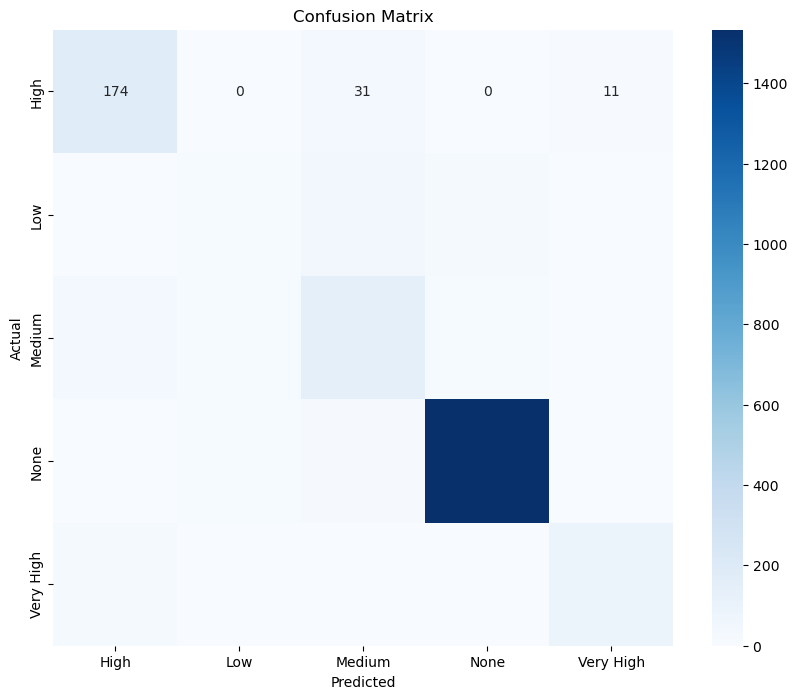

In [198]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [199]:
# drop weather_description_Unknown column
merged_test_data_encoded = merged_test_data_encoded.drop(columns=['weather_description_Unknown'])

In [203]:
best_estimator.get_booster().feature_names

['Normal (kWh)',
 'Economy Hours (kWh)',
 'Self-consumption (kWh)',
 'temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'wind_speed',
 'rain_1h',
 'clouds_all',
 'temperature_2m',
 'relative_humidity_2m',
 'dew_point_2m',
 'apparent_temperature',
 'precipitation',
 'rain',
 'snowfall',
 'snow_depth',
 'weather_code',
 'pressure_msl',
 'surface_pressure',
 'cloud_cover',
 'cloud_cover_low',
 'cloud_cover_mid',
 'cloud_cover_high',
 'wind_speed_10m',
 'wind_speed_100m',
 'wind_direction_10m',
 'wind_direction_100m',
 'wind_gusts_10m',
 'is_day',
 'sunshine_duration',
 'shortwave_radiation',
 'direct_radiation',
 'diffuse_radiation',
 'direct_normal_irradiance',
 'terrestrial_radiation',
 'shortwave_radiation_instant',
 'direct_radiation_instant',
 'diffuse_radiation_instant',
 'direct_normal_irradiance_instant',
 'terrestrial_radiation_instant',
 'is_holiday',
 'weather_description_broken clouds',
 'weather_description_few clouds',
 'weather_description_heavy int

In [204]:
merged_test_data_encoded.columns

Index(['Normal (kWh)', 'Economy Hours (kWh)', 'Self-consumption (kWh)', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'is_holiday', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low',
       'cloud_cover_mid', 'cloud_cover_high', 'wind_speed_10m',
       'wind_speed_100m', 'wind_direction_10m', 'wind_direction_100m',
       'wind_gusts_10m', 'is_day', 'sunshine_duration', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'terrestrial_radiation', 'shortwave_radiation_instant',
       'direct_radiation_instant', 'diffuse_radiation_instant',
       'direct_normal_irradiance_instant', 'terrestrial_radiation_instant',
       'weather_description_broken clouds', 'weather_descr

In [205]:
# Reorder columns in merged_test_data_encoded to match the order in best_estimator
merged_test_data_encoded = merged_test_data_encoded[best_estimator.get_booster().feature_names]

# Now try making predictions
test_predictions = best_estimator.predict(merged_test_data_encoded)

In [206]:
# Inverse transform the predictions if you used LabelEncoder
test_predictions_labels = le.inverse_transform(test_predictions)

In [207]:
# Create a DataFrame for submission
submission = pd.DataFrame({
    'RowId': range(1, len(test_predictions_labels) + 1),
    'Result': test_predictions_labels
})

In [208]:
# Save the DataFrame to a CSV file for submission
submission.to_csv('kaggle_submission_is_holiday.csv', index=False)